# **Librerias**

In [1]:
from utils.data import divideData
from utils.model import tuneHyperparameters
from utils.evaluate import modelEvaluation, modelEvaluationWithThreshold
import pandas as pd
import numpy as np
import joblib
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from dotenv import load_dotenv
warnings.filterwarnings('ignore')
load_dotenv()

True

# **Carga de datos**

In [2]:
READ_DATA_PATH = os.getenv("TRAIN_PROCESSED_DATA_PATH")
RF_MODEL_PATH = os.getenv("RF_MODEL_PATH")
LR_MODEL_PATH = os.getenv("LR_MODEL_PATH")

In [3]:
df =  pd.read_excel(str("../"+READ_DATA_PATH))

# **Feature engineering**

Definir las caracteristicas de las que el modelo aprenderá

In [4]:
df['EFICIENCIA'] = df['ASIST_PROM'] * (1 - df['PROP_REPROB'])

In [5]:
features = [
    'PROM_PERIODO',
    'ASIST_PROM',
    'TOTAL_MAT',
    'REPROBADAS',
    'REPITENCIAS',
    'NIVEL', 
    'PROP_REPROB',
    'EFICIENCIA'
    ]

**División de datos en `train/test`**

La partición de los datos se realizó respetando el orden temporal de los períodos académicos, utilizando los ciclos más antiguos para entrenamiento y los más recientes para prueba, con el fin de simular un escenario real de predicción y evitar sesgos por fuga de información.

In [6]:
X_train, X_test, y_train, y_test = divideData(df, features)

# Modelo

## Ramdon Forest

In [7]:
rf = tuneHyperparameters(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'smote__sampling_strategy': 'auto', 'smote__k_neighbors': 7, 'rf__n_estimators': 500, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 3, 'rf__max_features': 'sqrt', 'rf__max_depth': 9, 'rf__criterion': 'gini'}
Best F1 macro: 0.7578


In [10]:
rf.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(k_neighbors=7, random_state=42)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=9,
                                        min_samples_leaf=3,
                                        min_samples_split=10, n_estimators=500,
                                        random_state=42))])

CV ROC-AUC: 84.62%
CV Accuracy: 86.99%
Test ROC-AUC: 92.51%
Test Accuracy: 92.36%
Balanced Accuracy: 86.14%

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       143
           1       0.55      0.79      0.65        14

    accuracy                           0.92       157
   macro avg       0.76      0.86      0.80       157
weighted avg       0.94      0.92      0.93       157



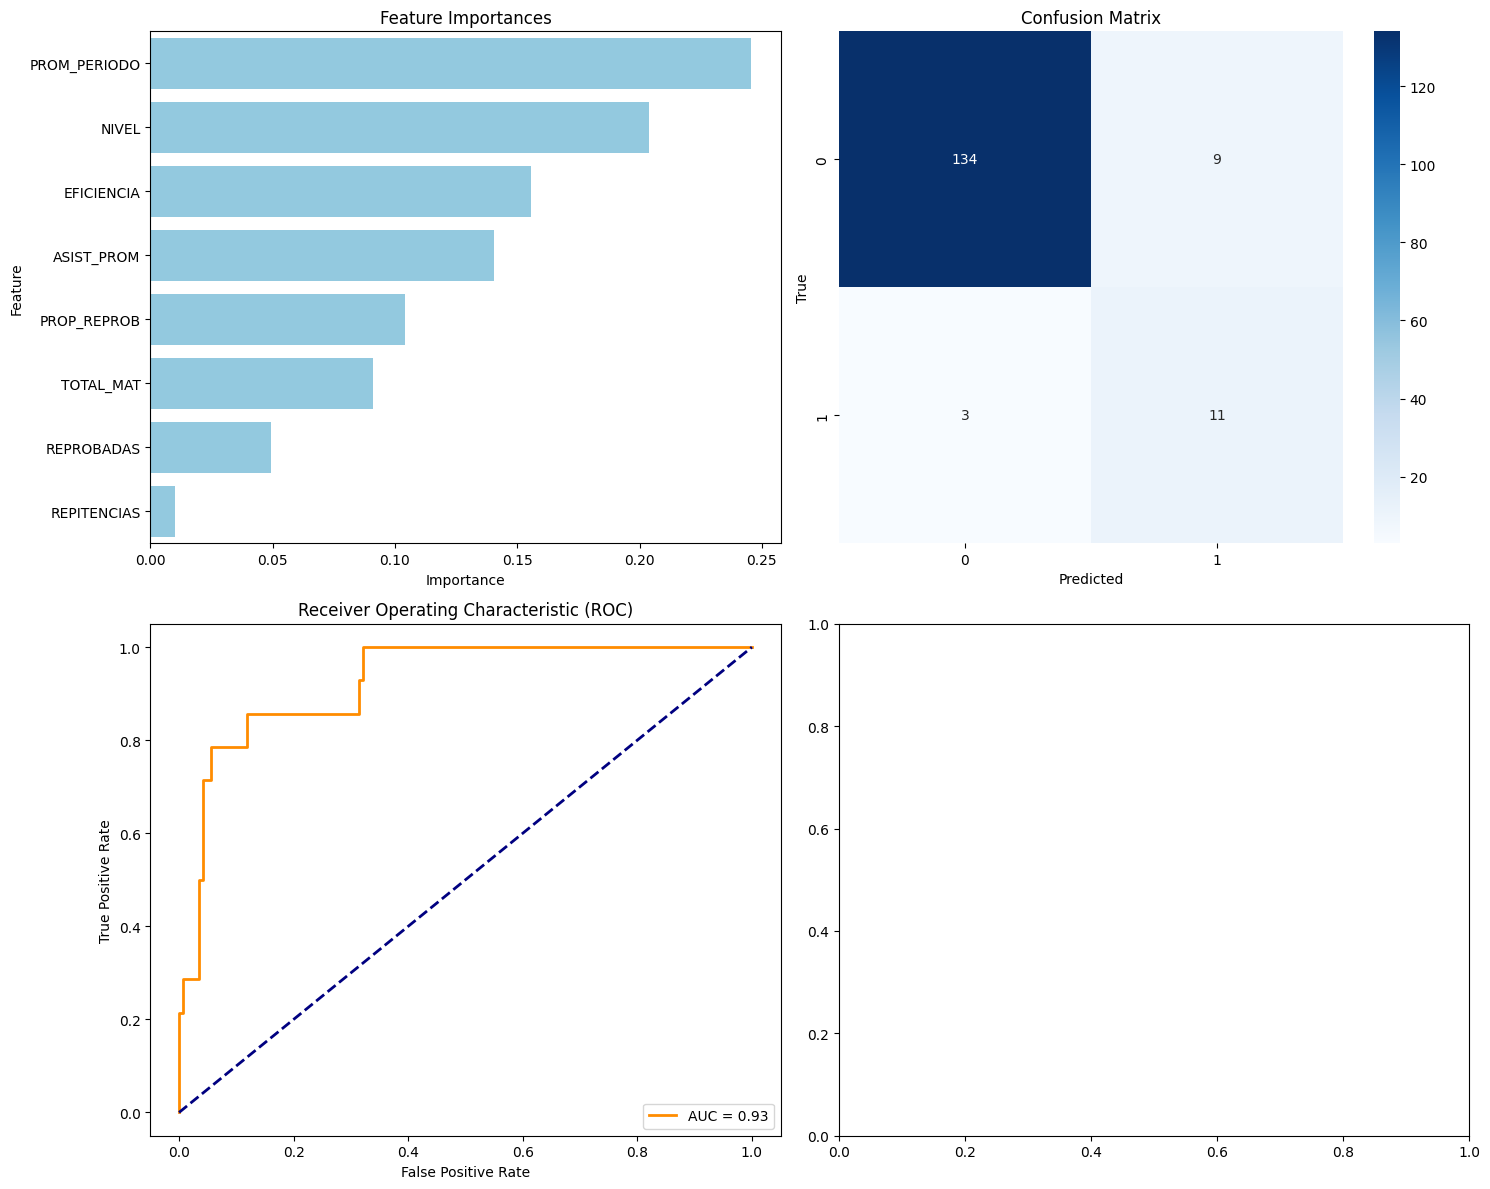

In [12]:
modelEvaluation(
    rf,
    df[features],
    df['RIESGO_t1'],
    X_test,
    y_test
    )

In [11]:
y_proba = rf.predict_proba(X_test)[:, 1]

Selected threshold: 0.51

Recall (dropout): 0.79
Precision: 0.58
F1-score: 0.67
Balanced Accuracy: 0.86
ROC-AUC: 0.93

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       143
           1       0.58      0.79      0.67        14

    accuracy                           0.93       157
   macro avg       0.78      0.86      0.81       157
weighted avg       0.94      0.93      0.93       157



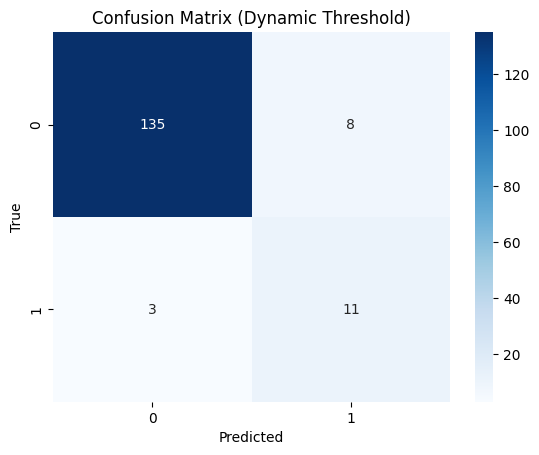

In [12]:
rf_best_threshold = modelEvaluationWithThreshold(rf, X_train, y_train, X_test, y_test)

### Guardar modelo

In [12]:
artifact = {
    "model": rf,
    "threshold": rf_best_threshold,
    "features": rf.named_steps['rf'].feature_names_in_,
    "model_version": "rf_dropout_v1"
}

joblib.dump(artifact, f"../{RF_MODEL_PATH}")

['../artifacts/dropout_rf_v1.joblib']

## Logistic Regression

In [60]:
lr = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(
        random_state=42
        )),
    ('lr', LogisticRegression(
        solver="liblinear",
        C=0.01,
        max_iter=700,
        class_weight="balanced",
        penalty='l2'
        ))
    ])

In [61]:
lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('lr',
                 LogisticRegression(C=0.01, class_weight='balanced',
                                    max_iter=700, solver='liblinear'))])

CV ROC-AUC: 65.43%
CV Accuracy: 80.08%
Test ROC-AUC: 80.17%
Test Accuracy: 84.08%
Balanced Accuracy: 78.37%

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       143
           1       0.32      0.71      0.44        14

    accuracy                           0.84       157
   macro avg       0.65      0.78      0.68       157
weighted avg       0.91      0.84      0.87       157



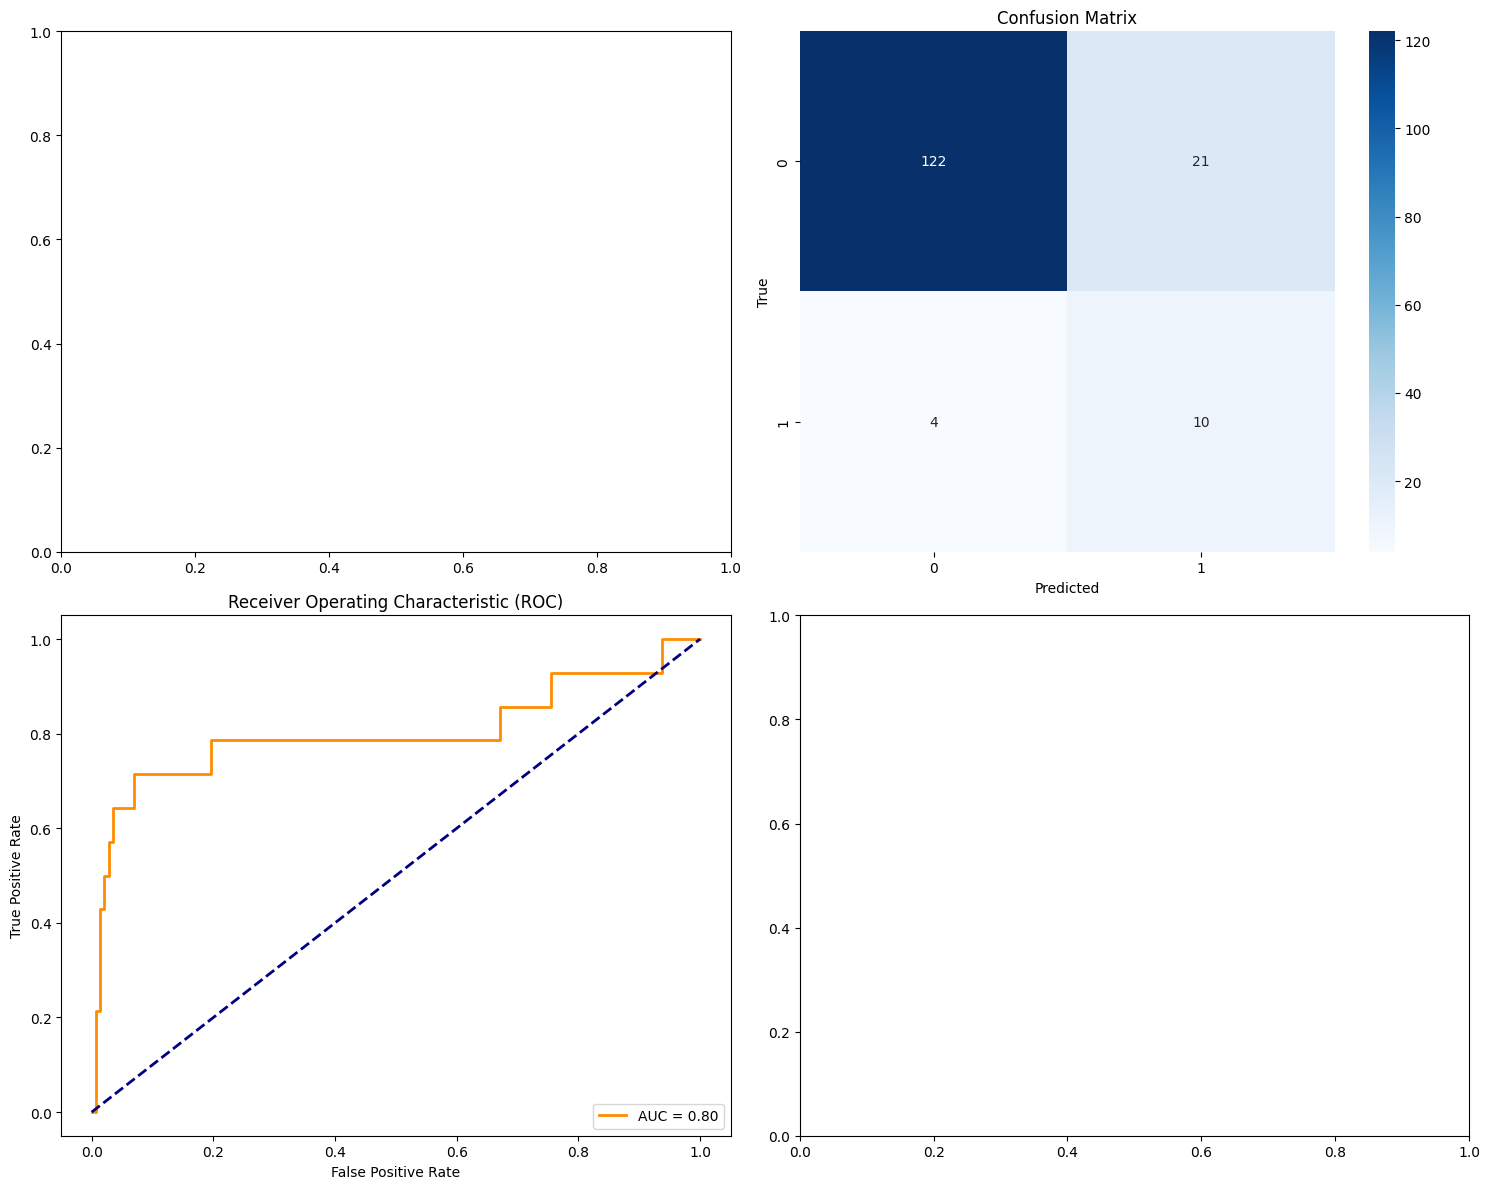

In [62]:
modelEvaluation(
    lr,
    df[features],
    df['RIESGO_t1'],
    X_test,
    y_test
    )

In [63]:
importancias = pd.DataFrame({
    'Variable': X_train.columns,
    'Coeficiente': lr.named_steps['lr'].coef_[0]
}).sort_values(by='Coeficiente', ascending=False)
importancias['Odds_Ratio'] = np.exp(importancias['Coeficiente'])
print(importancias)

       Variable  Coeficiente  Odds_Ratio
6   PROP_REPROB     0.144819    1.155831
1    ASIST_PROM     0.143429    1.154225
3    REPROBADAS     0.142845    1.153551
2     TOTAL_MAT    -0.050966    0.950311
4   REPITENCIAS    -0.091495    0.912566
0  PROM_PERIODO    -0.102279    0.902778
7    EFICIENCIA    -0.116809    0.889755
5         NIVEL    -0.264358    0.767699


In [64]:
y_proba = lr.predict_proba(X_test)[:, 1]

Selected threshold: 0.59

Recall (dropout): 0.64
Precision: 0.64
F1-score: 0.64
Balanced Accuracy: 0.80
ROC-AUC: 0.80

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       143
           1       0.64      0.64      0.64        14

    accuracy                           0.94       157
   macro avg       0.80      0.80      0.80       157
weighted avg       0.94      0.94      0.94       157



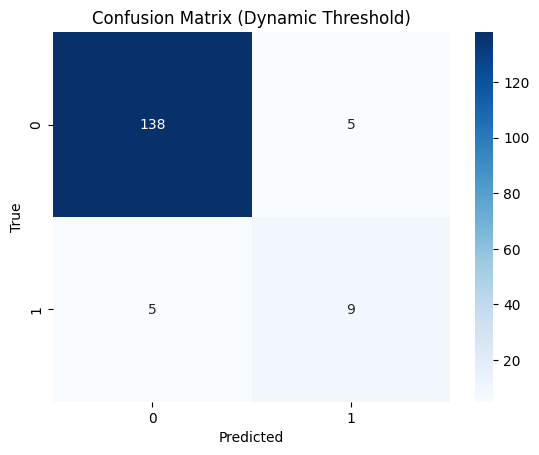

In [65]:
lr_best_threshold = modelEvaluationWithThreshold(lr, X_train, y_train, X_test, y_test)

### Guardar modelo

In [66]:
artifact = {
    "model": lr,
    "threshold": lr_best_threshold,
    "features": lr.feature_names_in_,
    "model_version": "lr_dropout_v1"
}

joblib.dump(artifact, f"../{LR_MODEL_PATH}")

['../artifacts/dropout_lr_v1.joblib']

Los modelos entrenados y umbrales de decisión fueron almacenados como artefactos, permitiendo desacoplar el proceso de entrenamiento del proceso de inferencia. Esta estrategia garantiza la reproducibilidad de las predicciones y facilita la adaptación del sistema a distintos escenarios institucionales sin necesidad de reentrenar el modelo.